In [7]:
# import dontenv, cargar las variables de entorno y mostrar OPENAI_API_KEY Y TAVILY_API_KEY
import dotenv

dotenv.load_dotenv()

True

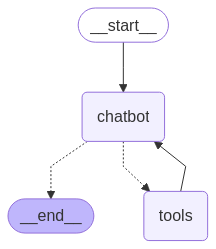

In [8]:
from IPython.display import Image, display

from typing import Annotated, TypedDict, List
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# 1. Modelo y herramienta local
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
tavily_tool = TavilySearchResults(max_results=2)
tools = [tavily_tool]                       # <-- solo Tavily
llm_with_tools = llm.bind_tools(tools)

# 2. Estado
class ChatState(TypedDict):
    messages: Annotated[List, add_messages]

# 3. Nodos
def chatbot(state: ChatState):
    resp = llm_with_tools.invoke(state["messages"])
    return {"messages": [resp]}

tool_node = ToolNode(tools)

# 4. Grafo mínimal (START → chatbot → tools → chatbot …)
builder = StateGraph(ChatState)
builder.add_node("chatbot", chatbot)
builder.add_node("tools", tool_node)
builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
graph = builder.compile(checkpointer=MemorySaver())

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # Si no tienes las dependencias de GraphViz, muestra ASCII
    print(graph.get_graph().draw_ascii())

# 5. Helper para probar
def ask(query: str):
    cfg = {"configurable": {"thread_id": "demo1"}}
    events = graph.stream({"messages": [{"role": "user", "content": query}]},
                          cfg, stream_mode="values")
    for ev in events:
        if "messages" in ev:
            print("🤖", ev["messages"][-1].content)

In [9]:
ask("¿Quién fundó RappiPay?")

🤖 ¿Quién fundó RappiPay?
🤖 
🤖 [{"title": "RappiPay: key figures 2022 - Statista", "url": "https://www.statista.com/statistics/1356680/key-figures-rappipay-colombia/", "content": "RappiPay is the fintech founded in 2019 by Colombian startup Rappi and Banco Davivienda. By 2022, the financial platform had more than 800,000", "score": 0.85216236}, {"title": "Rappi - Wikipedia", "url": "https://en.wikipedia.org/wiki/Rappi", "content": "History\n\nRappi was founded in 2015 by three Colombian entrepreneurs: Simón Borrero, Felipe Villamarin, and Sebastián Mejía.[4]\n\nRappi entered Y Combinator's Winter 2016 batch, generating additional investment.[5][6] In August 2018, the company raised another $200 million in funding.[7] SoftBank became a major stakeholder in Rappi in April 2019 with a $1 billion investment that valued Rappi at $3.5 billion.[8][9] [...] Company type | Private\nIndustry | Online food orderingE-commerceFinancial technology\nFounded | 2015; 10 years ago(2015)\nFounders | Simón

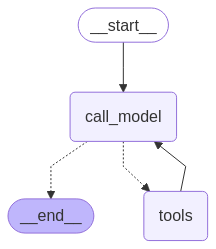

🔢 Math: {'messages': [HumanMessage(content="what's (3 + 5) x 12?", additional_kwargs={}, response_metadata={}, id='76c1bc0f-4f72-4b3f-893b-25a79046dce1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5caWdTxr3uLzl5r1pH4edX7X', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 135, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BUvYG4cLtMZklgzWai4nRAlOBbU6L', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7aacb1be-2a8a-4f7f-91de-f0f4f80c2c30-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_5caWdTxr3uLzl5r1pH4edX7X',

In [10]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from IPython.display import display

model = ChatOpenAI(model="gpt-4o")

async def main():
    async with MultiServerMCPClient(
        {
            "math": {
                "command": "python",
                "args": ["./math_server.py"],  # cambia la ruta si es necesario
                "transport": "stdio",
            },
            "weather": {
                "url": "http://localhost:8000/sse",
                "transport": "sse",
            }
        }
    ) as client:
        tools = client.get_tools()

        def call_model(state: MessagesState):
            response = model.bind_tools(tools).invoke(state["messages"])
            return {"messages": response}

        builder = StateGraph(MessagesState)
        builder.add_node("call_model", call_model)
        builder.add_node("tools", ToolNode(tools))

        builder.add_edge(START, "call_model")
        builder.add_conditional_edges("call_model", tools_condition)
        builder.add_edge("tools", "call_model")

        graph = builder.compile()

        try:
            display(Image(graph.get_graph().draw_mermaid_png()))
        except Exception:
            print(graph.get_graph().draw_ascii())



        math_response = await graph.ainvoke({"messages": "what's (3 + 5) x 12?"})
        print("🔢 Math:", math_response)

        weather_response = await graph.ainvoke({"messages": "what is the weather in nyc?"})
        print("🌦️ Weather:", weather_response)

# Ejecutar en notebook
await main()

In [24]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from IPython.display import display
from langgraph.graph import END

model = ChatOpenAI(model="gpt-4o")

async def main():
    async with MultiServerMCPClient(
        {
            "math": {
                "command": "python",
                "args": ["./math_server.py"],
                "transport": "stdio",
            },
            "weather": {
                "url": "http://localhost:8000/sse",
                "transport": "sse",
            }
        }
    ) as client:
        tavily_tool = TavilySearchResults(max_results=2)
        tools = client.get_tools() + [tavily_tool]
        print(tools)    

        def call_model(state: MessagesState):
            response = model.bind_tools(tools).invoke(state["messages"])
            return {"messages": response}

        builder = StateGraph(MessagesState)
        builder.add_node("call_model", call_model)
        builder.add_node("tools", ToolNode(tools))

        builder.add_edge(START, "call_model")
        builder.add_conditional_edges("call_model", tools_condition)
        builder.add_edge("tools", "call_model")

        graph = builder.compile()


        return graph  # 👈 retornar grafo compilado

# Ejecuta esto en una celda
graph = await main()

[StructuredTool(name='add', description='Add two numbers', args_schema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'addArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x10ddb6320>), StructuredTool(name='multiply', description='Multiply two numbers', args_schema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'multiplyArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x10ddb63b0>), StructuredTool(name='buscar_contratos_por_ruc', args_schema={'properties': {'ruc': {'title': 'Ruc', 'type': 'string'}}, 'required': ['ruc'], 'title': 'buscar_contratos_por_rucArguments', 'type': 'object'}, response_format='content_and_artifact', coro

In [25]:
agent_response = await graph.ainvoke({"messages": "what's 10 x 2 + 5?"})
for msg in agent_response["messages"]:
    print(msg.pretty_print())

================================ Human Message =================================

what's 10 x 2 + 5?
None
================================== Ai Message ==================================
Tool Calls:
  multiply (call_7y39RC7P9rKsqxtpzQdNuzZQ)
 Call ID: call_7y39RC7P9rKsqxtpzQdNuzZQ
  Args:
    a: 10
    b: 2
  add (call_y8CFqLydTIG8Vi85MJrGYnM5)
 Call ID: call_y8CFqLydTIG8Vi85MJrGYnM5
  Args:
    a: 20
    b: 5
None
================================= Tool Message =================================
Name: multiply

Error: ClosedResourceError()
 Please fix your mistakes.
None
================================= Tool Message =================================
Name: add

Error: ClosedResourceError()
 Please fix your mistakes.
None
================================== Ai Message ==================================

There was an error performing the calculations. Let me try calculating it directly.

To solve \(10 \times 2 + 5\), you do the multiplication first:

1. Multiply 10 by 2 to get 20.
2. Add 5

In [26]:
await graph.ainvoke({"messages": "what's the weather in Cusco?"})

{'messages': [HumanMessage(content="what's the weather in Cusco?", additional_kwargs={}, response_metadata={}, id='33bb99f0-985b-4a58-ac7b-97e371f58194'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IngFFKiAZwsdJPi8BKeBX33A', 'function': {'arguments': '{"query":"current weather in Cusco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 187, 'total_tokens': 210, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BUvfGuJSOJz5Ej4hQbRtGKSmrfDed', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9be6bd50-c31d-4277-a294-9196515ae911-0', tool_calls=[{'name': 'tavily_search_results_